# OPEC Sentiment Index

This notebook builds a stable, reusable OPEC sentiment index from previously generated FinBERT and GPT outputs. No external API calls are made; everything runs from saved artifacts.

In [1]:
from pathlib import Path
import sys
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

NOTEBOOK_DIR = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
ROOT = NOTEBOOK_DIR.parent
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.opec_sentiment_utils import (
    build_opec_sentiment_index,
    plot_opec_index_sections,
    plot_opec_index_hybrid,
    plot_opec_index_changes,
)

DATA = ROOT / "data"
ART = ROOT / "artifacts"
PLOTS = ROOT / "plots"
for path in (ART, PLOTS):
    path.mkdir(parents=True, exist_ok=True)

pd.set_option("display.max_columns", 20)
print(f"ROOT set to {ROOT}")


ROOT set to c:\PythonProjects\LLM-polypropylene


In [2]:
raw_df = pd.DataFrame()
monthly_section_scores = pd.DataFrame()
monthly_index = pd.DataFrame()

try:
    outputs = build_opec_sentiment_index(ROOT)
    raw_df = outputs.get("raw", pd.DataFrame())
    monthly_section_scores = outputs.get("monthly_section_scores", pd.DataFrame())
    monthly_index = outputs.get("monthly_index", pd.DataFrame())
except Exception as exc:
    print(f"Failed to build sentiment index: {exc}")

if raw_df.empty or monthly_index.empty:
    print("No sentiment data available; downstream steps will be skipped.")
else:
    print(f"Raw rows: {len(raw_df)}, months: {raw_df['report_date'].dt.to_period('M').nunique()}")
    print(f"Monthly section scores shape: {monthly_section_scores.shape}")
    print(f"Monthly index shape: {monthly_index.shape}")
    display(raw_df.head())
    display(raw_df.tail())
    min_date = raw_df['report_date'].min()
    max_date = raw_df['report_date'].max()
    print(f"Coverage: {min_date.date()} to {max_date.date()}")


Discovered 2 finbert file(s).
Discovered 1 gpt file(s).
Discovered 5 other file(s).
Loaded sentiment files:
  - FinBERT -> c:\PythonProjects\LLM-polypropylene\data\reports\energy\opec\opec_features_finbert.csv
  - FinBERT -> c:\PythonProjects\LLM-polypropylene\data\reports\energy\opec\opec_features_finbert_chunked.csv
  - GPT -> c:\PythonProjects\LLM-polypropylene\data\reports\energy\opec\opec_comparison_scores_gpt.csv
Total rows: 745, unique months: 82
Report dates aligned to month-end using explicit date columns, year/month fields, or filename tokens.
Index coverage: 2019-01-31 to 2025-11-30
Raw rows: 745, months: 82
Monthly section scores shape: (83, 4)
Monthly index shape: (83, 9)


,report_date,section,sentiment_finbert,sentiment_gpt,source_file,base_sentiment,section_clean
0,2019-01-31,World Oil Demand,0.999967,NaN,c:\PythonProjects\LLM-polypropylene\data\repor...,0.999967,demand
1,2019-01-31,Product Markets and Refining Operations,0.606347,NaN,c:\PythonProjects\LLM-polypropylene\data\repor...,0.606347,price_outlook
2,2019-01-31,Balance of Supply and Demand,-0.572259,NaN,c:\PythonProjects\LLM-polypropylene\data\repor...,-0.572259,demand
3,2019-01-31,World Oil Supply,0.220044,NaN,c:\PythonProjects\LLM-polypropylene\data\repor...,0.220044,supply
4,2019-01-31,World Oil Demand,0.186915,NaN,c:\PythonProjects\LLM-polypropylene\data\repor...,0.186915,demand


,report_date,section,sentiment_finbert,sentiment_gpt,source_file,base_sentiment,section_clean
740,2025-11-30,Product Markets and Refining Operations,1.440677e-07,NaN,c:\PythonProjects\LLM-polypropylene\data\repor...,1.440677e-07,price_outlook
741,2025-11-30,World Oil Supply,-9.999998e-01,NaN,c:\PythonProjects\LLM-polypropylene\data\repor...,-9.999998e-01,supply
742,2025-11-30,World Oil Demand,-1.583414e-07,NaN,c:\PythonProjects\LLM-polypropylene\data\repor...,-1.583414e-07,demand
743,2025-11-30,World Oil Demand,-9.812627e-05,NaN,c:\PythonProjects\LLM-polypropylene\data\repor...,-9.812627e-05,demand
744,2025-11-30,hybrid,NaN,0.3,c:\PythonProjects\LLM-polypropylene\data\repor...,3.000000e-01,overall


Coverage: 2019-01-31 to 2025-11-30


In [3]:
if raw_df.empty or monthly_index.empty:
    print("Skipping CSV export; sentiment tables are empty.")
else:
    exports = {
        ART / "opec_sentiment_raw_long.csv": raw_df,
        ART / "opec_sentiment_monthly_section_scores.csv": monthly_section_scores.reset_index().rename(columns={"index": "report_date"}),
        ART / "opec_sentiment_monthly_index.csv": monthly_index.reset_index().rename(columns={"index": "report_date"}),
    }
    for path, df in exports.items():
        df.to_csv(path, index=False)
        print(f"Saved -> {path}")


Saved -> c:\PythonProjects\LLM-polypropylene\artifacts\opec_sentiment_raw_long.csv
Saved -> c:\PythonProjects\LLM-polypropylene\artifacts\opec_sentiment_monthly_section_scores.csv
Saved -> c:\PythonProjects\LLM-polypropylene\artifacts\opec_sentiment_monthly_index.csv


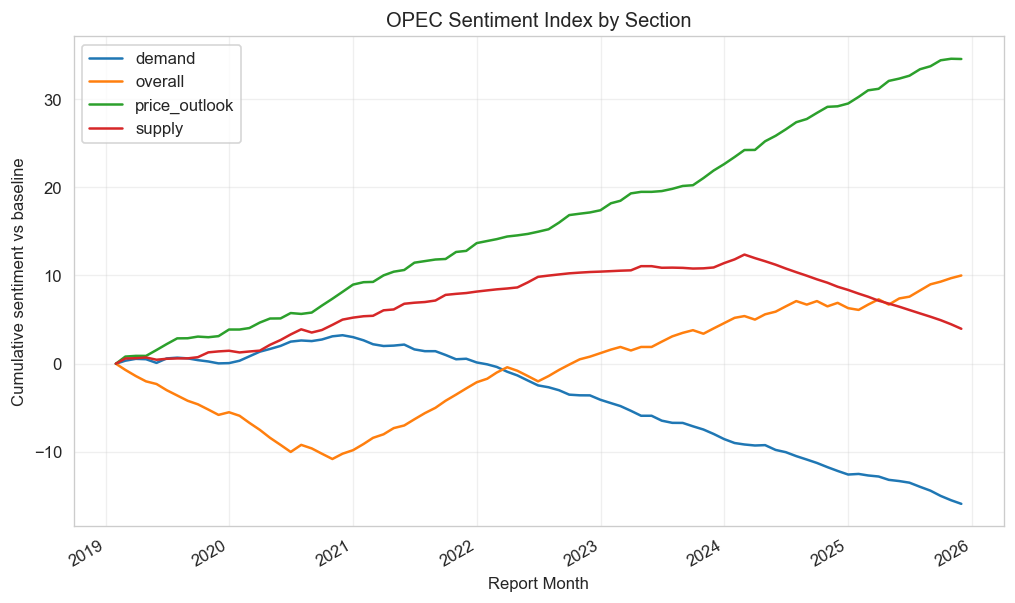

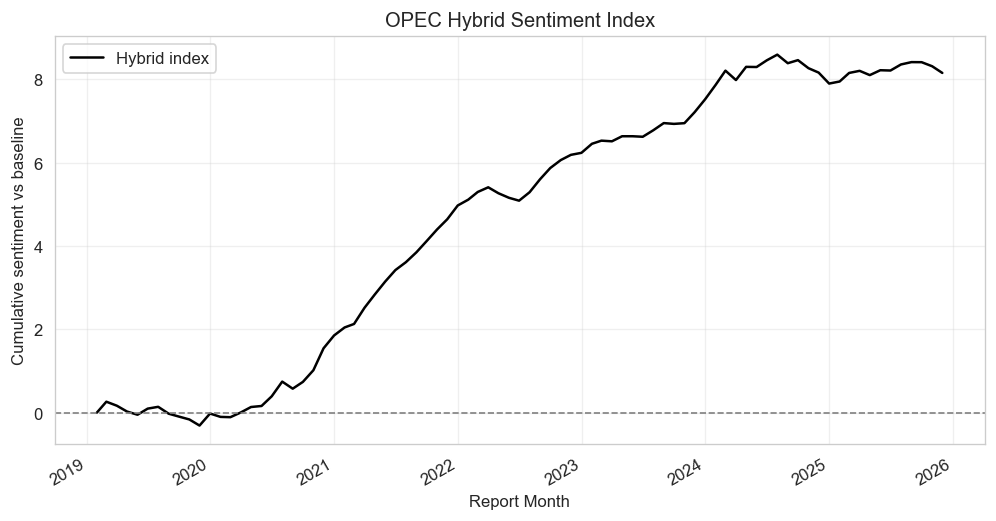

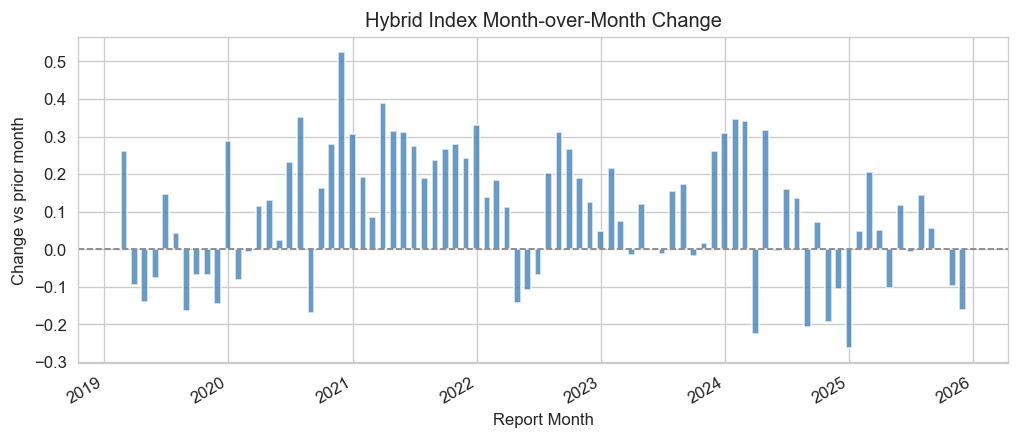

In [4]:
if monthly_index.empty:
    print("Skipping plots; monthly_index is empty.")
else:
    try:
        fig_sections = plot_opec_index_sections(monthly_index)
        sections_path = PLOTS / "opec_index_sections.png"
        fig_sections.savefig(sections_path, dpi=150, bbox_inches="tight")
        display(fig_sections)
    except Exception as exc:
        print(f"Section plot failed: {exc}")
    finally:
        plt.close('all')

    try:
        fig_hybrid = plot_opec_index_hybrid(monthly_index)
        hybrid_path = PLOTS / "opec_index_hybrid.png"
        fig_hybrid.savefig(hybrid_path, dpi=150, bbox_inches="tight")
        display(fig_hybrid)
    except Exception as exc:
        print(f"Hybrid plot failed: {exc}")
    finally:
        plt.close('all')

    try:
        fig_changes = plot_opec_index_changes(monthly_index)
        changes_path = PLOTS / "opec_index_hybrid_changes.png"
        fig_changes.savefig(changes_path, dpi=150, bbox_inches="tight")
        display(fig_changes)
    except Exception as exc:
        print(f"Change plot failed: {exc}")
    finally:
        plt.close('all')


In [5]:
if monthly_index.empty:
    print("No sentiment index to interpret.")
else:
    start = monthly_index.index.min().date()
    end = monthly_index.index.max().date()
    hybrid_series = monthly_index.get("index_hybrid")
    latest_val = hybrid_series.dropna().iloc[-1] if hybrid_series is not None and not hybrid_series.dropna().empty else float('nan')
    min_month = hybrid_series.idxmin().date() if hybrid_series is not None and not hybrid_series.dropna().empty else None
    max_month = hybrid_series.idxmax().date() if hybrid_series is not None and not hybrid_series.dropna().empty else None

    print(f"Index spans {start} to {end}.")
    print(f"Hybrid index range: {hybrid_series.min():.2f} to {hybrid_series.max():.2f}; latest = {latest_val:.2f}.")
    if min_month and max_month:
        print(f"Trough around {min_month}, peak around {max_month}.")
    print("This index will be merged with PP returns and residuals in a later notebook for forecasting experiments.")


Index spans 2019-01-31 to 2025-11-30.
Hybrid index range: -0.31 to 8.59; latest = 8.15.
Trough around 2019-11-30, peak around 2024-07-31.
This index will be merged with PP returns and residuals in a later notebook for forecasting experiments.
